Comparing two bayesian regressors 
- `Automatic Relevance Determination (ARD)`
- `Bayesian Ridge Regression`

Chekcing models robutness to recover the ground truth weights 

In [1]:
#Generating dataset 

from sklearn.datasets import make_regression 

X, y, true_weights = make_regression(n_samples=100, n_features=100,n_informative=10, noise=8, coef=True, random_state=42)

In [2]:
#fitting both regressors, and using Ordinary Least Square (OLS) to compare the model's coefficients 

import pandas as pd 

from sklearn.linear_model import ARDRegression, LinearRegression, BayesianRidge 

ordinary_linear_reg = LinearRegression().fit(X, y)
bayesian_ridge_reg = BayesianRidge(compute_score=True, n_iter=30).fit(X, y)
auto_relevance_det = ARDRegression(compute_score=True, n_iter=30).fit(X, y)

In [3]:
df = pd.DataFrame(
    {
    "Weights of true generative process": true_weights, 
    "ARDRegression": auto_relevance_det.coef_,
    "BayesianRidge": bayesian_ridge_reg.coef_,
    "LinearReg": ordinary_linear_reg.coef_,
    }
) 
df.head()

,Weights of true generative process,ARDRegression,BayesianRidge,LinearReg
0,0.000000,-0.590226,-0.631933,3.419469
1,0.000000,-0.001504,-3.250621,-2.792213
2,0.000000,-0.000594,-2.509021,-4.735213
3,0.000000,-0.000171,2.541967,7.699233
4,32.125517,33.179873,34.489623,37.136316


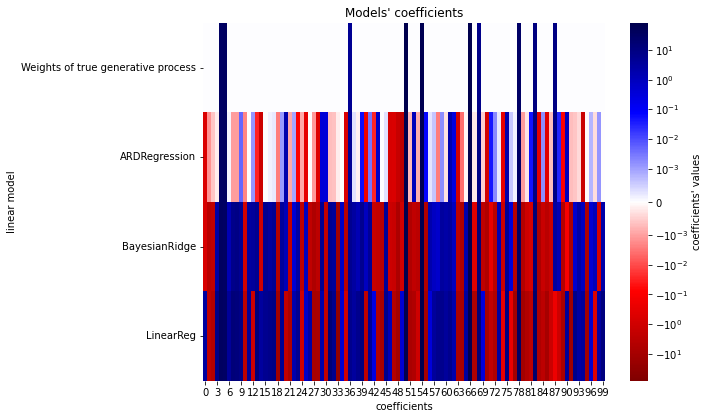

In [4]:
#Plotting the true and estimated coefficients 

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import SymLogNorm

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    df.T,
    norm=SymLogNorm(linthresh=10e-4, vmin=-80, vmax=80),
    cbar_kws={"label": "coefficients' values"},
    cmap="seismic_r")

plt.ylabel("linear model")
plt.xlabel("coefficients")
plt.tight_layout(rect=(0, 0, 1, 0.95))
viz = plt.title("Models' coefficients")


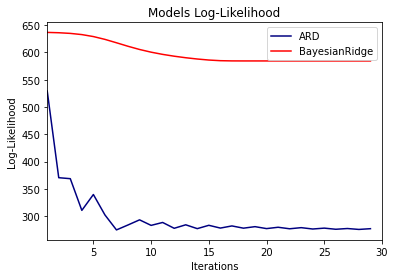

In [5]:
#Plotting the marginal log-likelihood

import numpy as np 

auto_relevance_det_scores = -np.array(auto_relevance_det.scores_)
bayesian_ridge_reg_scores = -np.array(bayesian_ridge_reg.scores_)

plt.plot(auto_relevance_det_scores, color="navy",label="ARD")
plt.plot(bayesian_ridge_reg_scores, color="red", label="BayesianRidge")
plt.ylabel("Log-Likelihood")
plt.xlabel("Iterations")
plt.xlim(1, 30)
plt.legend()
v = plt.title("Models Log-Likelihood")

`Bayesian Regressions` with polynomial feature expansion 

In [6]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler 

In [7]:
rng = np.random.RandomState(0)
n_samples = 110 

#sorting the data to make plotting easier  

X = np.sort(-10 * rng.rand(n_samples) + 10)
noise = rng.normal(0, 1, n_samples) * 1.35 
y = np.sqrt(X) * np.sin(X) + noise 

full_data = pd.DataFrame({"input_feature":X, "target": y})
X = X.reshape((-1,1))

In [8]:
full_data

,input_feature,target
0,0.116262,1.630905
1,0.213817,-0.144781
2,0.232389,-1.334494
3,0.235405,1.536673
4,0.363372,-0.330035
...,...,...
105,9.608122,-0.204614
106,9.797816,-1.193802
107,9.798925,-2.720991
108,9.812102,-0.476732


In [9]:
#extrapolation 
X_plot = np.linspace(10, 10.4, 10)
y_plot = np.sqrt(X_plot) * np.sin(X_plot)
X_plot = np.concatenate((X, X_plot.reshape((-1,1))))
y_plot = np.concatenate((y - noise, y_plot))

In [10]:
#Fitting thr regressors

ard_poly = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    StandardScaler(),
    ARDRegression()
).fit(X, y)

brr_poly = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    StandardScaler(),
    BayesianRidge(),
).fit(X, y)

y_ard, y_ard_std = ard_poly.predict(X_plot, return_std = True)
y_brr, y_brr_std = brr_poly.predict(X_plot, return_std = True)


Plotting Polynomial Bayesian Regressions - ARD and BayesianRidge, with STD errors 

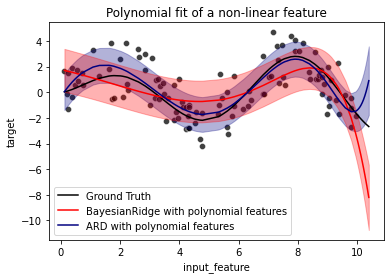

In [11]:
import seaborn as sns
ax = sns.scatterplot(data=full_data, x="input_feature", y="target", color="black", alpha=0.75)

ax.plot(X_plot, y_plot, color="black", label="Ground Truth")
ax.plot(X_plot, y_brr, color="red", label="BayesianRidge with polynomial features")
ax.plot(X_plot, y_ard, color="navy", label="ARD with polynomial features")
ax.fill_between(
    X_plot.ravel(),
    y_ard - y_ard_std,
    y_ard + y_ard_std,
    color="navy",
    alpha=0.3,
)
ax.fill_between(
    X_plot.ravel(),
    y_brr - y_brr_std,
    y_brr + y_brr_std,
    color="red",
    alpha=0.3,
)
ax.legend()
_ = ax.set_title("Polynomial fit of a non-linear feature")